In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.2f}".format)

In [3]:
df = pd.read_csv("bengali_content_moderation_synthetic.csv")


In [4]:
df.head()

,content_id,timestamp,text,platform,content_type,language_form,text_category,emoji_used,ai_flagged,user_reported,native_reviewer_offensive,escalation_source,time_to_action_hours,crisis_period
0,C1,10-01-2025 16:35,kichu bolar nei 😏 #0,Facebook,Ad,Romanized,Meme,0,0,0,1,NaN,13,Normal
1,C2,04-04-2025 09:25,eta khub bhalo kotha #1,Facebook,Comment,Romanized,Political,0,0,0,0,NaN,16,Protest
2,C3,24-04-2025 19:31,sobai jane eta ki #2,Facebook,Post,Romanized,Political,0,0,0,0,NaN,7,Protest
3,C4,06-04-2025 05:52,sobai jane eta ki 🔥 #3,Instagram,Comment,Romanized,Political,1,0,0,0,NaN,8,Normal
4,C5,02-05-2025 03:24,sobai jane eta ki 🤡 #4,Facebook,Comment,Romanized,Social,0,0,0,0,NaN,23,Normal


In [5]:
df.shape

(10000, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   content_id                 10000 non-null  object
 1   timestamp                  10000 non-null  object
 2   text                       10000 non-null  object
 3   platform                   10000 non-null  object
 4   content_type               10000 non-null  object
 5   language_form              10000 non-null  object
 6   text_category              10000 non-null  object
 7   emoji_used                 10000 non-null  int64 
 8   ai_flagged                 10000 non-null  int64 
 9   user_reported              10000 non-null  int64 
 10  native_reviewer_offensive  10000 non-null  int64 
 11  escalation_source          94 non-null     object
 12  time_to_action_hours       10000 non-null  int64 
 13  crisis_period              10000 non-null  object
dtypes: int6

In [8]:
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M")


In [9]:
df["platform"].value_counts(normalize=True)
df["content_type"].value_counts(normalize=True)
df["text_category"].value_counts(normalize=True)
df["crisis_period"].value_counts(normalize=True)

crisis_period
Normal     0.60
Election   0.25
Protest    0.15
Name: proportion, dtype: float64

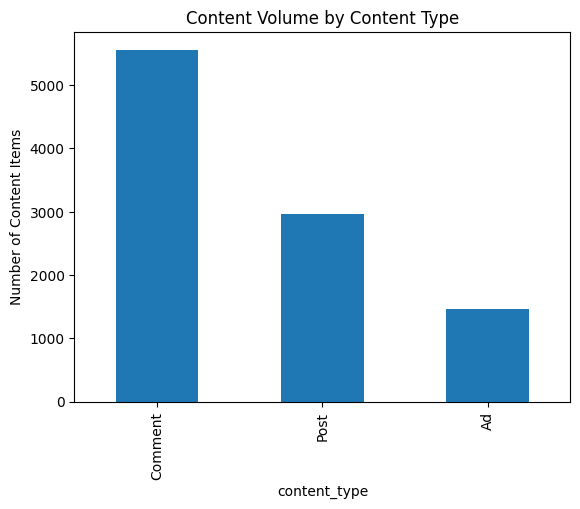

In [10]:
df["content_type"].value_counts().plot(
    kind="bar",
    title="Content Volume by Content Type"
)
plt.ylabel("Number of Content Items")
plt.show()

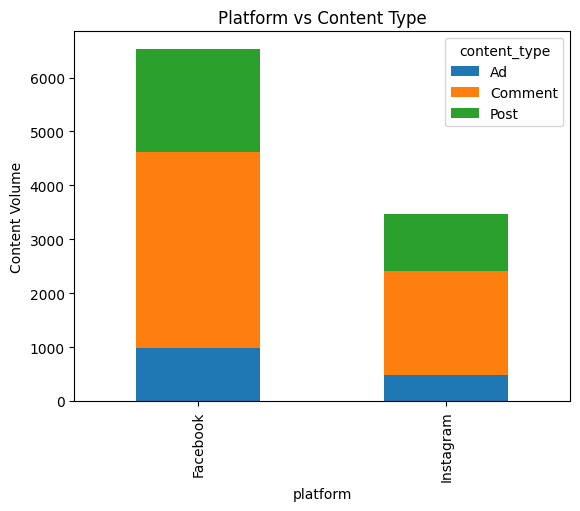

In [11]:
platform_content = pd.crosstab(df["platform"], df["content_type"])
platform_content.plot(kind="bar", stacked=True, title="Platform vs Content Type")
plt.ylabel("Content Volume")
plt.show()

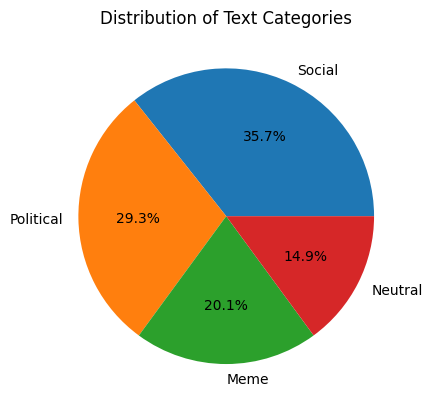

In [12]:
df["text_category"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    title="Distribution of Text Categories"
)
plt.ylabel("")
plt.show()

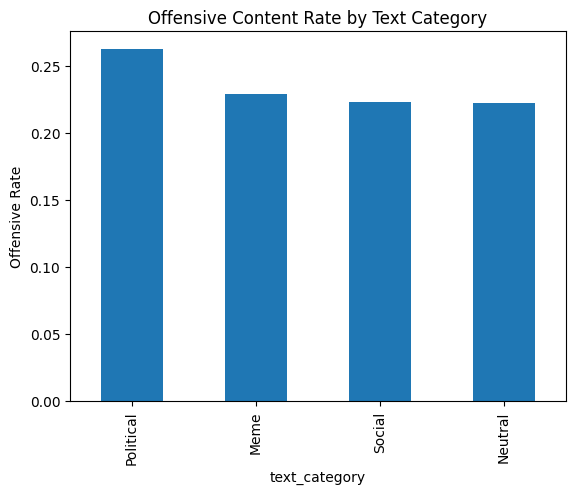

In [13]:
offensive_rate = (
    df.groupby("text_category")["native_reviewer_offensive"]
    .mean()
    .sort_values(ascending=False)
)

offensive_rate.plot(kind="bar", title="Offensive Content Rate by Text Category")
plt.ylabel("Offensive Rate")
plt.show()

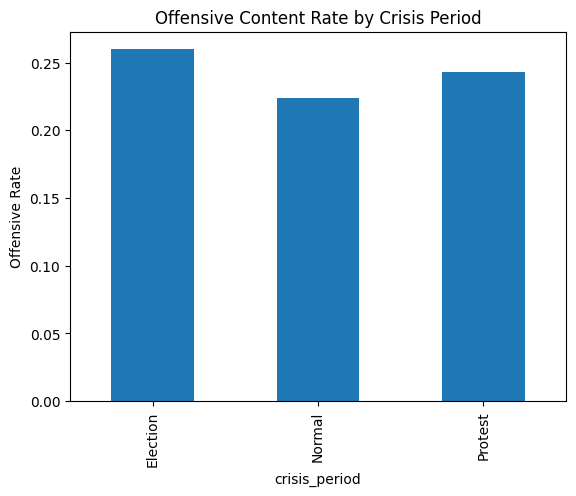

In [14]:
crisis_offensive = (
    df.groupby("crisis_period")["native_reviewer_offensive"]
    .mean()
)

crisis_offensive.plot(kind="bar", title="Offensive Content Rate by Crisis Period")
plt.ylabel("Offensive Rate")
plt.show()

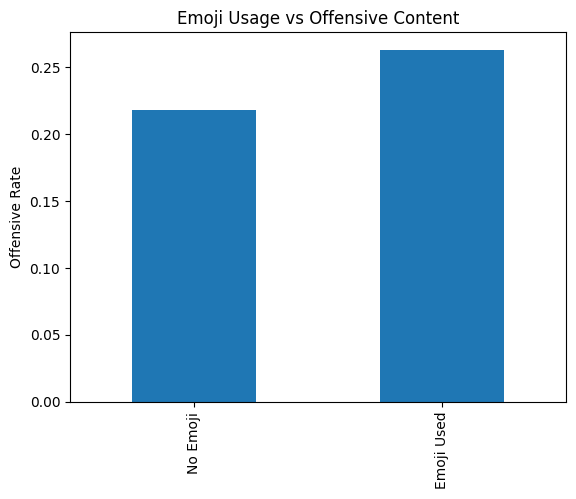

In [15]:
emoji_offensive = (
    df.groupby("emoji_used")["native_reviewer_offensive"]
    .mean()
)

emoji_offensive.index = ["No Emoji", "Emoji Used"]
emoji_offensive.plot(kind="bar", title="Emoji Usage vs Offensive Content")
plt.ylabel("Offensive Rate")
plt.show()

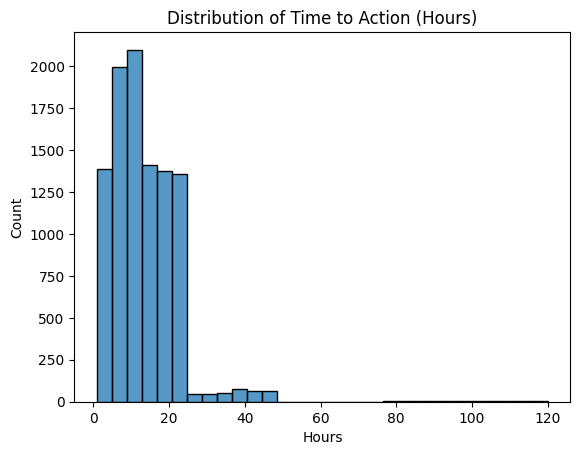

In [16]:
sns.histplot(df["time_to_action_hours"], bins=30)
plt.title("Distribution of Time to Action (Hours)")
plt.xlabel("Hours")
plt.show()

In [17]:
df["false_negative"] = np.where(
    (df["native_reviewer_offensive"] == 1) & (df["ai_flagged"] == 0),
    1,
    0
)

In [18]:
df["silent_harm"] = np.where(
    (df["native_reviewer_offensive"] == 1) &
    (df["ai_flagged"] == 0) &
    (df["user_reported"] == 0),
    1,
    0
)

In [ ]:
df["is_crisis"] = np.where(df["crisis_period"] != "Normal", 1, 0)



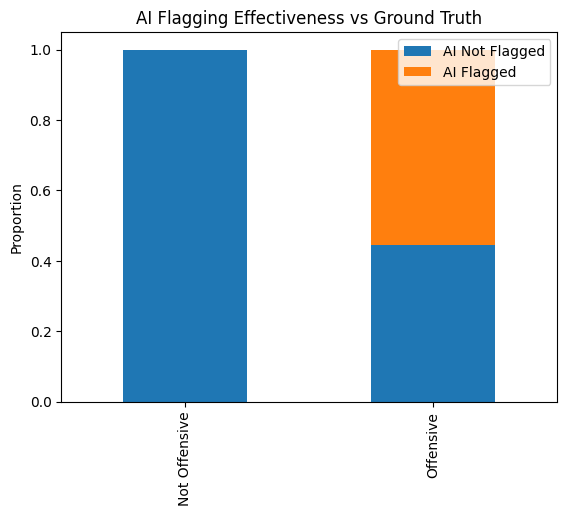

In [23]:
ai_effectiveness = pd.crosstab(
    df["native_reviewer_offensive"],
    df["ai_flagged"],
    normalize="index"
)

ai_effectiveness.columns = ["AI Not Flagged", "AI Flagged"]
ai_effectiveness.index = ["Not Offensive", "Offensive"]

ai_effectiveness.plot(
    kind="bar",
    stacked=True,
    title="AI Flagging Effectiveness vs Ground Truth"
)
plt.ylabel("Proportion")
plt.show()


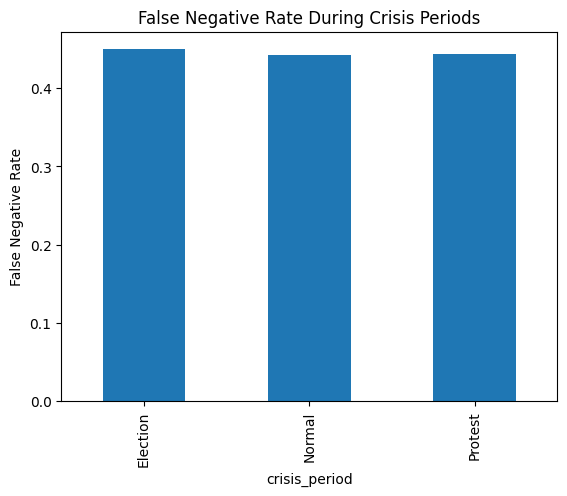

In [24]:
fn_by_crisis = (
    df[df["native_reviewer_offensive"] == 1]
    .groupby("crisis_period")["false_negative"]
    .mean()
)

fn_by_crisis.plot(
    kind="bar",
    title="False Negative Rate During Crisis Periods"
)
plt.ylabel("False Negative Rate")
plt.show()


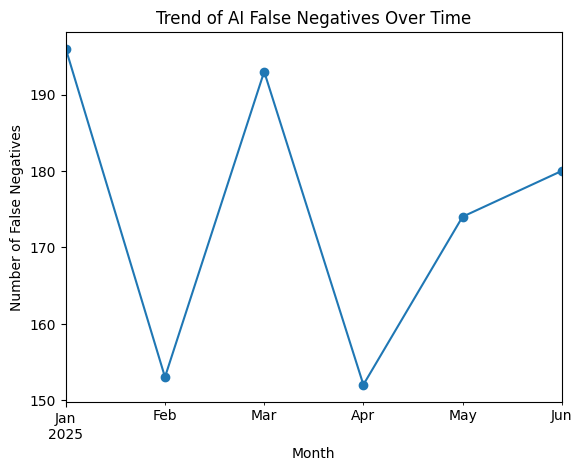

In [25]:
df["month"] = df["timestamp"].dt.to_period("M")

fn_time = (
    df[df["false_negative"] == 1]
    .groupby("month")
    .size()
)

fn_time.plot(
    kind="line",
    marker="o",
    title="Trend of AI False Negatives Over Time"
)
plt.ylabel("Number of False Negatives")
plt.xlabel("Month")
plt.show()


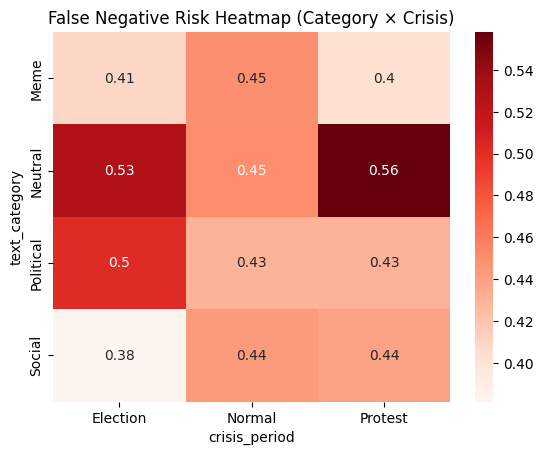

In [26]:
risk_matrix = (
    df[df["native_reviewer_offensive"] == 1]
    .pivot_table(
        values="false_negative",
        index="text_category",
        columns="crisis_period",
        aggfunc="mean"
    )
)

sns.heatmap(
    risk_matrix,
    annot=True,
    cmap="Reds"
)
plt.title("False Negative Risk Heatmap (Category × Crisis)")
plt.show()


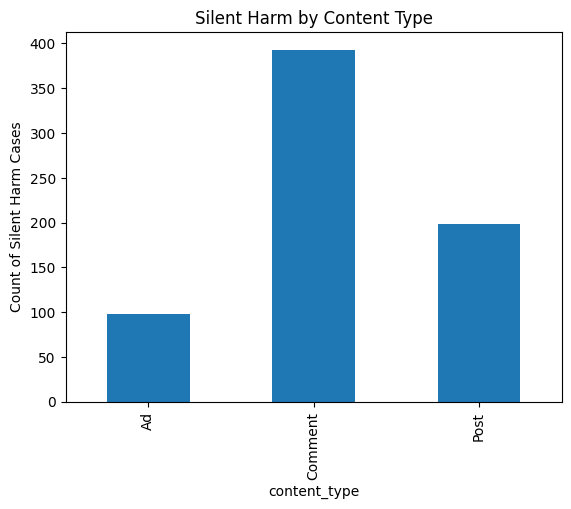

In [27]:
silent_harm_ct = (
    df[df["silent_harm"] == 1]
    .groupby("content_type")
    .size()
)

silent_harm_ct.plot(
    kind="bar",
    title="Silent Harm by Content Type"
)
plt.ylabel("Count of Silent Harm Cases")
plt.show()


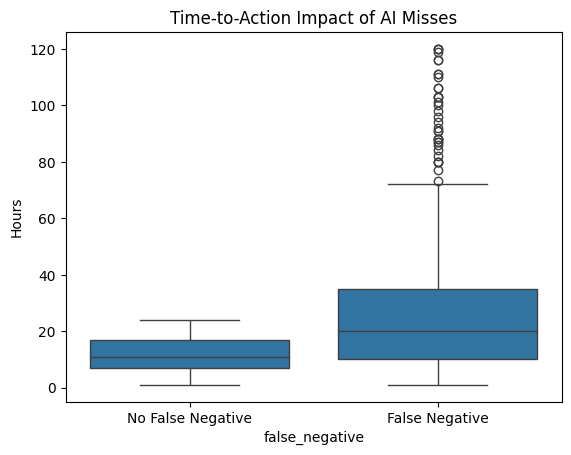

In [28]:
sns.boxplot(
    x="false_negative",
    y="time_to_action_hours",
    data=df
)

plt.xticks([0, 1], ["No False Negative", "False Negative"])
plt.title("Time-to-Action Impact of AI Misses")
plt.ylabel("Hours")
plt.show()
